### Importing Required Libraries for Data Preparation

In [1]:
# Import libraries
import os
import sys
import fiona
import osgeo
import folium
import shapely
import tensorflow
import numpy as np
import imgaug as ia
import rasterio as rio
import geopandas as gpd
from utils import *
from glob import glob
from osgeo import gdal
from rasterio import plot
from folium import plugins
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import box
from rasterio.merge import merge
from shapely.geometry import Point
from matplotlib import pyplot as plt
from imgaug import augmenters as iaa
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


sys.path.append('~/Thesis/Data')


### Stack Image (R,G,B,NIR,Slope and Aspect) Prepartion
* Reading Multispectral Images
* Reading Topographical Layers
* Stacking slope and aspect as the 5th and 6th band with RGB-NIR image
* If available and sensible to use, other data layers contributing for the landslideprocess can be stacked together in the similar fashon   

In [ ]:
# List of multispectral images
multispectral_list = ["Train_Img.tif","Test_Img.tif"]  ## add other images if there is separated by comma (,) and inside quotation marks(" ")

# Function to stack the multiple rasters

def stack_slope_aspect(input_folder, output_folder, multispectral_list, slope_folder, aspect_folder):
    for satellite_image in multispectral_list:
        # Load multispectral image
        multispectral_path = os.path.normpath(os.path.join(input_folder, satellite_image))
        with rasterio.open(multispectral_path) as src:
            multispectral_data = src.read()
            transform = src.transform

        # Load slope and aspect bands
        slope_path = os.path.join(slope_folder, f"{satellite_image[:-4]}.tif")
        aspect_path = os.path.join(aspect_folder, f"{satellite_image[:-4]}.tif")

        # Open slope and aspect datasets without using the 'with' statement
        slope_src = rasterio.open(slope_path)
        aspect_src = rasterio.open(aspect_path)

        try:
            # Read slope and aspect data
            slope_data = slope_src.read(
                out_shape=(multispectral_data.shape[1], multispectral_data.shape[2]),
                resampling=Resampling.bilinear
            )

            aspect_data = aspect_src.read(
                out_shape=(multispectral_data.shape[1], multispectral_data.shape[2]),
                resampling=Resampling.bilinear
            )

            # Stack bands
            stacked_data = np.concatenate([multispectral_data, slope_data, aspect_data], axis=0)

            # Update metadata for the new raster
            metadata = src.meta.copy()
            metadata.update({
                'count': stacked_data.shape[0],
                'transform': transform
            })


            # Save the stacked image
            output_path = os.path.join(output_folder, f"{satellite_image[:-4]}.tif")
            with rasterio.open(output_path, 'w', **metadata) as dst:
                dst.write(stacked_data)

        finally:
            # Close slope and aspect datasets
            slope_src.close()
            aspect_src.close()
    print(multispectral_path)

# Function Execution:
input_folder = "~/Thesis/Data/Imgs"
slope_folder = "~/Thesis/Data/Slope"
aspect_folder = "~/Thesis/Data/Aspects"
output_folder = "~/Thesis/Data/Stacked_Imgs"

stack_slope_aspect(input_folder, output_folder, multispectral_list, slope_folder, aspect_folder )


### Mask Prepartion
* Reading Multispectral/Stacked Images
* Reading Landslide Polygons
* Create the Binary Raster From Landslide Polygon 

In [27]:

# Directory paths for the Images and Labels folders
images_folder = "~/Thesis/Data/Imgs"       # needs to replace the folder when dealing with stacked image of MS and topographical layer by "~/Thesis/Data/Stacked_Imgs" 
labels_folder = "~/Thesis/Data/Lbls"

# Output folder for generated Masks
output_folder = "~/Thesis/Data/Masks"

# Loop through all files in the Images folder
for image_filename in os.listdir(images_folder):
    if image_filename.endswith(".tif"):
        # Construct the full paths for the current raster and shapefile
        raster_path = os.path.join(images_folder, image_filename)
        shape_filename = image_filename.replace(".tif", ".shp")
        shape_path = os.path.join(labels_folder, shape_filename)
        
        # Output file name for the mask (use the same name as the raster)
        mask_filename = image_filename
        
        # Generate the mask for the current pair of raster and shapefile
        generate_mask(raster_path=raster_path, shape_path=shape_path,
                      output_path=output_folder, file_name=mask_filename)

def readdata(directory, folder_name):

    data_path = os.path.join(directory, folder_name)
    data_list = {}

    for f in sorted(os.listdir(data_path)):
        fdir = os.path.join(data_path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-20:-4] # Number of characters of the image file. Example, "Image_1.tif" = 11 characters
            image_data=gdal.Open(fdir)
            bands = [image_data.GetRasterBand(i+1).ReadAsArray() for i in range(image_data.RasterCount)]
            data_list[imgtype] = np.stack(bands, axis=2)

    return data_list

data_folder = "~/Thesis/Data/"

image_list = readdata(directory=data_folder, folder_name="Imgs")                       # needs to replace the folder name when dealing with stacked image of MS and topographical layer by "Stacked_Imgs" 
label_list = readdata(directory=data_folder, folder_name="Masks")

# Print all the Images that are collected
print("The collection of images available in the list are:")
print("-"*30)
print(*image_list, sep='\n')

# Print all the Masks that are collected
print("The collection of labels available in the list are:")
print("-"*30)
print(*label_list, sep='\n')

c:\Users\ZDM\OneDrive - NOVAIMS\Thesis\Technical\Code\utils.py:236: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


The collection of images available in the list are:
------------------------------
1
10
11
12
13
2
3
4
5
6
7
8
9
Test_area
The collection of labels available in the list are:
------------------------------
1
10
11
12
13
2
3
4
5
6
7
8
9
Test_area


### Image Patch Generation
* Function defination for reading Images in gridwise manner
* Defining the patch size, Reading number of bands and assigning the list of images for gridwise sampling
* Concactinate grids of Images and Labels in their respective numpy arrays i.e X and Y 
* Here in this research we train the model with three different patch sizes i.e. 64 , 128, 256 which will create patches of size (192*192, 384*384, 768*768 sq m) since the imgage are of 3 m pixel size.


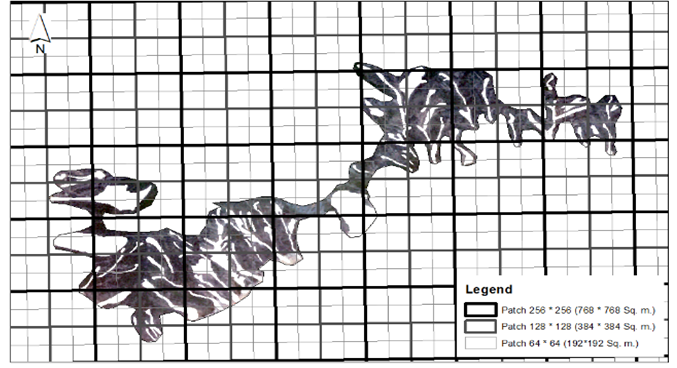

In [ ]:
# Cutting Images and Labels mask into defined patch sizes

# Function for patch generation
def gridwise_sample(imgarray, patchsize):

    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

# For Generatng Training Patches

PATCHSIZE = 64                                 # Change according to the required patch size
NBANDS = image_list["Train_Img"].shape[-1]

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.float32)

# Sample each training tile systematically in a gridwise manner
train_areas = ["Train_Img"]

for area in train_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)


Xtrain = Xtrain/255    # Normolization based on the bit depth of the image.for example image pixel of range (0-255), divide by 255,for any other wiith maximum value of the pixel
Ytrain[Ytrain==0] = 0
Ytrain[Ytrain==255] = 1
print(np.unique(Ytrain)) # should be [0,1] beacuse its a binary image classification

print("There are %i number of training patches" % (Xtrain.shape[0]))

In [ ]:
# Testing Patch Images and Labels Geneartion

# For generating Test Patches

PATCHSIZE = 64                            # Change according to the required patch size
NBANDS = image_list["Test_Img"].shape[-1]

Xtest = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytest = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.float32)

# Sample each training tile systematically in a gridwise manner
test_areas = ["Test_Img"]

for area in test_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
    Xtest = np.concatenate((Xtest, X_toadd), axis=0)
    Ytest = np.concatenate((Ytest, Y_toadd), axis=0)


Xtest = Xtest/255  # Normolization based on the bit depth of the image.for example image pixel of range (0-255), divide by 255,for any other wiith maximum value of the pixel
Ytest[Ytest==0] = 0
Ytest[Ytest==255] = 1
print(np.unique(Ytest))  # should be [0,1] beacuse its a binary image classification

print("There are %i number of test patches" % (Xtest.shape[0]))

### Filtering
* Filtering the X and Y arrays of training and testing patches without any data i.e. Patches with no data value pixels
* Number of patches depends on size of patch



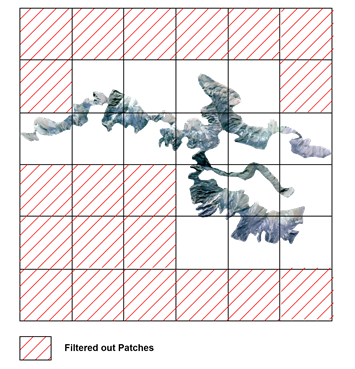 



In [ ]:
# Filtering the  training and testing patches

# Filtering Training Patches with all "no-value" pixels
nonzero_indices = np.all(Xtrain != 0, axis=(1, 2, 3))
filtered_X_train = Xtrain[nonzero_indices]
filtered_Y_train = Ytrain[nonzero_indices]

# Filtering Testing Patches with all "no-value" pixels
nonzero_indices = np.all(Xtest[:,:,:4] != 0, axis=(1,2,3))
filtered_X_test = Xtest[nonzero_indices]
filtered_Y_test = Ytest[nonzero_indices]

print("There are %i number of x training patches" % (filtered_X_train .shape[0]))
print("There are %i number of y training patches" % (filtered_Y_train .shape[0]))
print("There are %i number of x testng  patches" % (filtered_X_test .shape[0]))
print("There are %i number of y testng  patches" % (filtered_Y_test .shape[0]))


### Augumentation
* Reading filtered training and testing patches
* Applying augumentation such as rotation, flipping


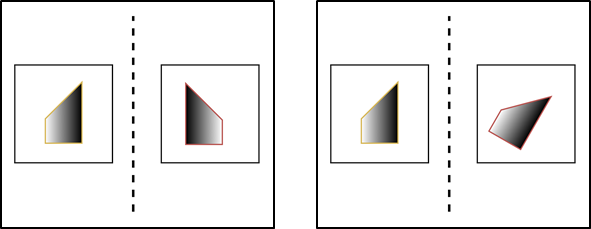

In [50]:
# Augumentations filtered of training and testing patches


# Define an augmentation sequence for each action
seq_rotation = iaa.Sequential([iaa.Affine(rotate=30)])
seq_horizontal_flip = iaa.Sequential([iaa.Fliplr(1.0)])
#seq_vertical_flip = iaa.Sequential([iaa.Flipud(1.0)])


# Apply augmentation to the filtered training patches
augmented_X_rotation = seq_rotation(images=filtered_X_train)
augmented_Y_rotation = seq_rotation(images=filtered_Y_train)
augmented_X_horizontal_flip = seq_horizontal_flip(images=filtered_X_train)
augmented_Y_horizontal_flip = seq_horizontal_flip(images=filtered_Y_train)
#augmented_X_vertical_flip = seq_vertical_flip(images=filtered_X_train)
#augmented_Y_vertical_flip = seq_vertical_flip(images=filtered_Y_train)


# Apply augmentation to the filtered testing patches
augmented_X_rotation = seq_rotation(images=filtered_X_test)
augmented_Y_rotation = seq_rotation(images=filtered_Y_test)
augmented_X_horizontal_flip = seq_horizontal_flip(images=filtered_X_test)
augmented_Y_horizontal_flip = seq_horizontal_flip(images=filtered_Y_test)
#augmented_X_vertical_flip = seq_vertical_flip(images=filtered_X_test)
#augmented_Y_vertical_flip = seq_vertical_flip(images=filtered_Y_test)

# Combine the augmented data with the original data
final_X_train = np.concatenate([filtered_X_train, augmented_X_rotation, augmented_X_horizontal_flip], axis=0)
final_Y_train = np.concatenate([filtered_Y_train, augmented_Y_rotation, augmented_Y_horizontal_flip], axis=0)

final_X_test = np.concatenate([filtered_X_test, augmented_X_rotation, augmented_X_horizontal_flip], axis=0)
final_Y_test = np.concatenate([filtered_Y_test, augmented_Y_rotation, augmented_Y_horizontal_flip], axis=0)

# Reshape the augumented data back to the original shape
final_X_train = np.squeeze(final_X_train)
final_Y_train = np.squeeze(final_Y_train)

final_X_test = np.squeeze(final_X_test)
final_Y_test = np.squeeze(final_Y_test)

# Check the shape of the augumented final data
print(f"Shape of final_X_train: {final_X_train.shape}")
print(f"Shape of final_Y_train: {final_Y_train.shape}")

print(f"Shape of final_X_test: {final_X_test.shape}")
print(f"Shape of final_Y_test: {final_Y_test.shape}")


Shape of final_X_train: (12243, 64, 64, 4)
Shape of final_Y_train: (12243, 64, 64)


### Data Split and Saving
* Spliting Training data into Training and Validation data sets with suitable ratio
* Saving training, validation and testing images as X_train, X_val, X_test and corresponding label patches as Y_train, Y_val and Y_test in numpy format


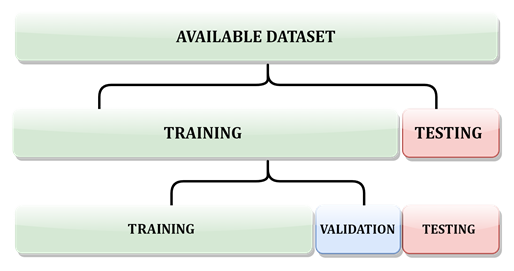

In [52]:
# Training and validation data split

X_train, X_val, Y_train, Y_val =train_test_split(final_X_train, final_Y_train, test_size=0.20, random_state=42)


# Saving Training, Validation and Testing datasets in Numpy array format

np.save('~/Thesis/Train_Model/MSI/Patch_256/arrays/X_train.npy', X_train)
np.save("~/Thesis/Train_Model/MSI/Patch_256/arrays/Y_train.npy", Y_train)

np.save("~/Thesis/Train_Model/MSI/Patch_256/arrays/X_val.npy", X_val)
np.save("~/Thesis/Train_Model/MSI/Patch_256/arrays/Y_val.npy", Y_val)

np.save("~/Thesis/Train_Model/MSI/Patch_256/arrays/X_test.npy", final_X_test)
np.save("~/Thesis/Train_Model/MSI/Patch_256/arrays/Y_test.npy", final_Y_test)

In [ ]:
# Visualise some data
for i in range(32):
    f, axarr = plt.subplots(1,2,figsize=(8,8))
    axarr[0].imshow(X_train[i][:,:,[2,1,0]])
    axarr[0].set_title("Satellite Image")
    axarr[1].imshow(np.squeeze(Y_train[i]))
    axarr[1].set_title("Label/Ground Truth Image")